In [337]:
import numpy as np
import itertools
import pyemma
from pyemma import msm
import warnings
warnings.filterwarnings('ignore')

In [338]:
import pyemma.plots as mplt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## simple topology

first look at a fairly simple case: a linear chain of $n$ unbound states, binding to $m$ bound states. 

special $\rightarrow$ unb $\rightarrow$  unb $\rightarrow$  ... $\rightarrow$  unb $\rightarrow$  unb $\rightarrow$  (some bound states)

In [351]:
def trans_matrix(n,m):
    t= np.zeros((n+m,n+m))

    for i,j in itertools.product(range(n),range(n)):
        if abs(i-j)==1:
            t[i,j]=10 # diffusional rate1
        
    for i,j in itertools.product(range(n,n+m),[n-1]):
        t[i,j]=2 #rate2
        t[j,i]=1 #rate3
    
    np.fill_diagonal(t,100.-t.sum(axis=1))
    tm = t/t.sum(axis=1)
    return tm


In [352]:
n=4
m=4
tm = trans_matrix(n,m)
mm=msm.markov_model(tm)
mm.stationary_distribution

array([ 0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.08333333,
        0.08333333,  0.08333333,  0.08333333])

In [353]:
mm.timescales(3)

array([ 49.70494533,  49.49831645,  49.49831645])

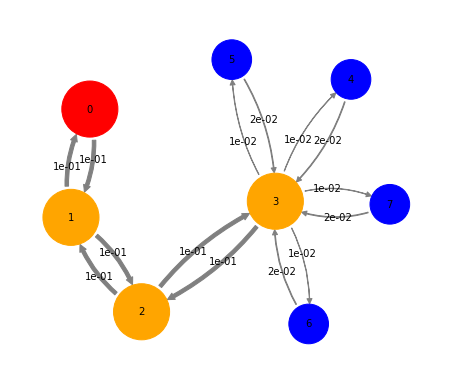

In [354]:
cols=['red']+(n-1)*['orange']+m*['blue']
dummy =mplt.plot_markov_model(mm,state_colors = cols,
                       max_width=8, max_height=8)

### compare special center $\rightleftharpoons$ anybound and anyunbound  $\rightleftharpoons$ anybound

switching from the special center to all unbound the on-rate stays roughly the same, the off-rate goes down. this makes sense since the off-rate

In [397]:
anybound = [5,6,7]
anyunbound = [0,1,2,3,4]
specialcenter = [0]
mm.mfpt(specialcenter,anybound),mm.mfpt(anybound,specialcenter)

(210.00000000000128, 169.99999999999966)

In [398]:
mm.mfpt(anyunbound,anybound) , mm.mfpt(anybound,anyunbound)

(186.66666666666771, 49.99999999999995)

on-rate: The mfpt _from_ anyunbound to anybound is  the average of the mfpt from each, weighed by the **conditional** prob

In [401]:
prob1 = mm.stationary_distribution[anyunbound]
prob1 = prob1/prob1.sum()
times_from_each = [mm.mfpt([j],anybound) for j in anyunbound]
times_from_each 


[210.00000000000128,
 200.00000000000119,
 180.00000000000099,
 150.00000000000071,
 200.00000000000054]

In [402]:
np.sum(times_from_each*prob1)

186.66666666666771

off-rate: the mfpt _to_ anyunbound is the **min** of the mfptimes to each (as soon as you reach one state of unbound, you're home

In [404]:
[mm.mfpt(anybound,[j]) for j in anyunbound]

[169.99999999999966,
 119.99999999999979,
 79.999999999999872,
 49.99999999999995,
 600.00000000000477]

### to/from each bound

In [290]:
## 0 to each bound
## is longer, since when we get to binding, we might end up in another state
## this should also change if the unbinding from the bound changes
[(mm.mfpt(specialcenter,[i]) , mm.mfpt([i],specialcenter))  for i in anybound]

[(610.00000000000693, 169.99999999999969),
 (610.00000000000693, 169.99999999999972),
 (610.00000000000693, 169.99999999999969)]

In [291]:
## unbound to any bound
[(mm.mfpt(anyunbound,[i]) , mm.mfpt([i],anyunbound)) for i in anybound]

[(586.66666666667288, 49.999999999999957),
 (586.66666666667288, 49.999999999999957),
 (586.66666666667288, 49.999999999999957)]

In [405]:
### check fes

In [406]:
mm.mfpt(anyunbound,anybound)/mm.mfpt(anybound,anyunbound)

3.7333333333333578

In [410]:
p_unb=mm.stationary_distribution[anyunbound].sum()
p_boun=mm.stationary_distribution[anybound].sum()
p_unb/p_boun

3.0000000000000981

In [411]:
mm.mfpt(specialcenter,anybound)/mm.mfpt(anybound,specialcenter)

1.2352941176470689

In [412]:
p_unb=mm.stationary_distribution[specialcenter].sum()
p_boun=mm.stationary_distribution[anybound].sum()
p_unb/p_boun

0.66666666666669572

# more complilcated topology

more similar to the real case, one special center, connected to several unbound states, each ending in a bound interface

In [427]:
def trans_mat_2(n1,n2, connect_unbound=False):
    n=n1*n2
    m=n2
    t= np.zeros((1+n+m,1+n+m))
    for i in np.array(range(n2))*n1:
        t[i, n+m] = 10
        t[n+m,i] = 10/3.
    for i,j in itertools.product(range(n),range(n)):
        if abs(i-j)==1 and (i // n1)==(j // n1):
            #print(i,j)
            t[i,j]=10
            t[j,i]=10
        if i!=j and (i % n1)==(j % n1) and connect_unbound:
            t[i,j]=6
            t[j,i]=6
    for k in range(1,n2+1):
        t[n1*k -1, (n-1) +k ]=2
        t[(n-1) +k ,n1*k -1]=1
        
    np.fill_diagonal(t,100.-t.sum(axis=1))
    tm = t/t.sum(axis=1)
    return tm

n1=2
n2=3
n = n1*n2
m = n2 ## no of bound states

tm2 = trans_mat_2(n1,n2,True)
mm2=msm.markov_model(tm2)
mm2.stationary_distribution

array([ 0.06666667,  0.06666667,  0.06666667,  0.06666667,  0.06666667,
        0.06666667,  0.13333333,  0.13333333,  0.13333333,  0.2       ])

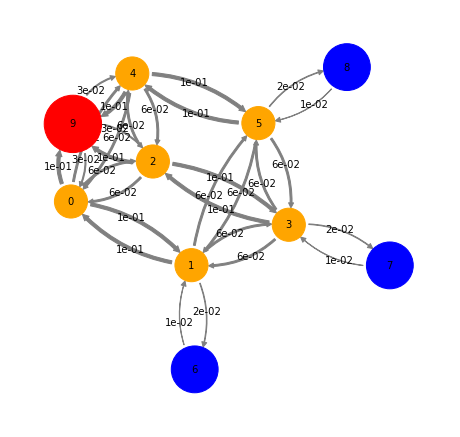

In [429]:
cols = n*['orange']+m*['blue']+['red']
qq=mplt.plot_markov_model(mm2,state_colors=cols,
                      max_width=8, max_height=8)

### compare special center $\rightleftharpoons$ anybound and anyunbound  $\rightleftharpoons$ anybound

switching from the special center to all unbound the on-rate stays roughly the same, the off-rate goes down

In [430]:
## 0 to any bound
## should not depend on unbinding rate

anybound=list(range(n,n+m))
specialcenter = [n+m]
anyunbound = list(range(n))+specialcenter

mm2.mfpt(specialcenter,anybound), mm2.mfpt(anybound,specialcenter)

(180.00000000000102, 169.99999999999983)

In [431]:
mm2.mfpt(anyunbound,anybound), mm2.mfpt(anybound,anyunbound)

(166.6666666666676, 99.999999999999915)

again, the binding is the average of the bindings, weighted by the conditional

In [432]:
times_from_each = [mm2.mfpt([i],anybound) for i in anyunbound]
times_from_each

[170.00000000000097,
 150.0000000000008,
 170.00000000000094,
 150.0000000000008,
 170.00000000000094,
 150.0000000000008,
 180.00000000000102]

In [433]:
prob1 = mm2.stationary_distribution[anyunbound]
prob1=prob1/prob1.sum()
prob1 

array([ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.11111111,  0.33333333])

In [267]:
#in this example the special center is very populated!

In [434]:
(times_from_each*prob1).sum()

166.6666666666676

In [1074]:
nangle=9
ndist=3
angle =np.linspace(0,2*np.pi*(1-1./nangle),nangle)
da = angle[1]-angle[0]


dist = np.linspace(1,10,ndist)
dd = dist[1]-dist[0]
grid1 = itertools.product(list(angle),list(dist))
stat = [item for item in grid1]

nbound = 2
to_b= np.ceil(np.linspace(1e-4,1,len(angle))*(nbound))-1

M=np.zeros((len(stat)+nbound,len(stat)+nbound))

for i,oi in enumerate(stat):
    for j,oj in enumerate(stat):
        if i!=j:
            if (abs(oi[1]-oj[1])<1e-4) and \
            (abs(oi[0]-oj[0])-da<1e-4 or abs(oi[0]-oj[0]-2*np.pi)-da<1e-4): 
                #print(oi,oj)
                #and abs(oi[0]-oj[0])==2*pi/(5-1) and abs(oi[1]-oj[1])==10/(5-1):
                M[i,j]=5.
                M[j,i]=5.
                #print(oi,oj)
            if abs(oi[0]-oj[0])==0 and abs(oi[1]-oj[1])==dd:
                M[i,j]=5.
                M[j,i]=5.
                #print(oi,oj)

for i,oi in enumerate(stat):
    anindex = np.where(angle==oi[0])[0][0]
    offset = len(stat)
    if(oi[1]==dist[0]):
        #print(i,oi,offset+to_b[anindex] )
        M[i,offset+to_b[anindex]]=5
        M[offset+to_b[anindex],i]=2

    
np.fill_diagonal(M,3500.-M.sum(axis=1))
tm3 = M/M.sum(axis=1)
tm3.sum(axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [1075]:
to_b

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.])

In [1076]:
mm3=msm.markov_model(tm3)
#mm3.stationary_distribution

In [1077]:
outer = dist[-1]+3
pos = [[np.cos(s[0])*(outer-s[1]),np.sin(s[0])*(outer-s[1])] 
       for s in stat] + [
    [np.cos(angle[to_b==s].mean())*(outer+4),
     np.sin(angle[to_b==s].mean())*(outer+4)] 
    for s in range(nbound)]

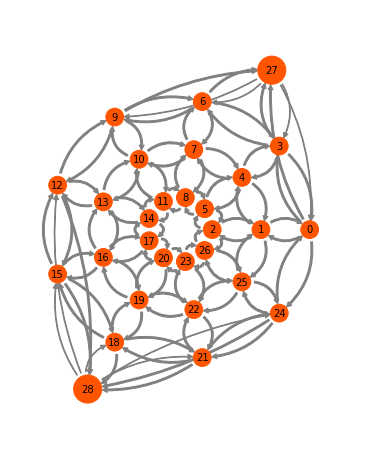

In [1079]:
qq=mplt.plot_markov_model(mm3, pos = np.array(pos),
                      max_width=8, max_height=8,arrow_labels=None)

In [1093]:
special = list(np.where([s[1]==dist[-1] for s in stat])[0])
bound = list(range(len(stat),len(stat)+nbound))
unbound = list(range(len(stat)))
tpt1=[ msm.tpt(mm3,special,[bounds]) for bounds in bound]


In [1094]:
#from sklearn.cluster import AgglomerativeClustering
#probs = np.vstack([tpt.forward_committor for tpt in tpt1]).T
#clust = AgglomerativeClustering(n_clusters=nbound+1)
#xx = clust.fit(probs)

def check_sep(cutoff,nbound):
    probs = np.vstack([tpt.forward_committor for tpt in tpt1]).T
    assign = (probs>cutoff).astype('int').sum(axis=1)
    ovelaps=assign>1
    if np.any(ovelaps):
        print("%d states overlap" % ovelaps.sum())
        raise
    else:
        bulk = (assign==0)
        print("Bulk has %d states" % bulk.sum())
        oo=(probs>cutoff).astype('int')
        states=(oo*(np.array(range(nbound))+1)).sum(axis=1)
        return states


In [1095]:
states_comm=check_sep(.5,2)
usets = [np.setdiff1d(np.where(states_comm==i+1)[0] ,bound[i]) for i in range(nbound)]

unboundstar=np.setdiff1d(unbound,np.concatenate(usets))

Bulk has 18 states


In [1096]:
states_comm

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 1, 2])

In [1097]:
col1=np.array(['red','blue','green','orange'])[states_comm]

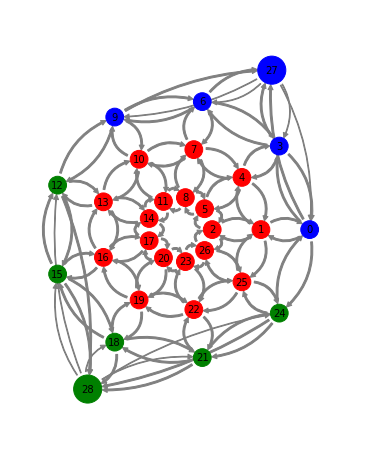

In [1098]:
qq=mplt.plot_markov_model(mm3, pos = np.array(pos), state_colors=col1,
                      max_width=8, max_height=8,arrow_labels=None)

In [1099]:
M

array([[  3.48000000e+03,   5.00000000e+00,   0.00000000e+00,
          5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.00000000e+00,   0.00000000e+00],
       [  5.00000000e+00,   3.48000000e+03,   5.00000000e+00,
          0.00000000e+00,   5.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,

In [1007]:
mm3.mfpt(usets[1],[bound[1]])

12043.235164867978

In [1032]:
mm3.mfpt(unboundstar,[bound[1]])

26993.659038177349

In [1030]:
tpt2=msm.tpt(mm3,A=unboundstar,B=[bound[1]])

In [1037]:
#tpt2.pathways(1.0)

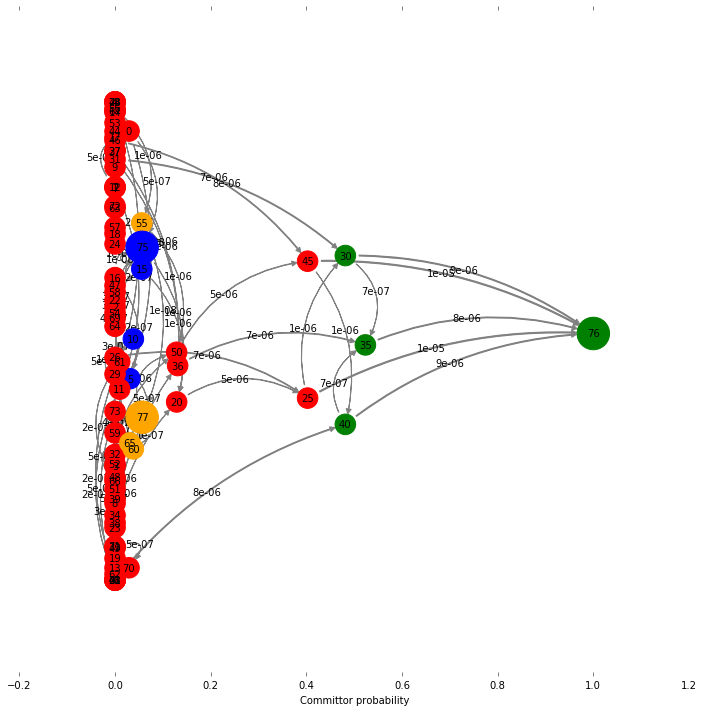

In [1036]:
rrr2=pyemma.plots.plot_flux(tpt2,state_colors=col1)